# SOSE HEAT BUDGET

(isel not sel)

In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
from dask.distributed import Client

client = Client("tcp://10.32.60.236:40135")
client

Client Scheduler: tcp://10.32.60.236:40135 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 46.00 GB


In [6]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [7]:
coords = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

## Heat budget for WG (entire water column)

In [20]:
dsr.Z[0]

<xarray.DataArray 'Z' ()>
array(-5., dtype=float32)
Coordinates:
    Z        float32 -5.0
Attributes:
    axis:           Z
    long_name:      vertical coordinate of cell center
    positive:       down
    standard_name:  depth
    units:          m

In [21]:
sst_mean = dsr.THETA.isel(Z=0).mean(dim='time').load()

In [22]:
surface_mask = (coords.hFacC[0]>0).load()

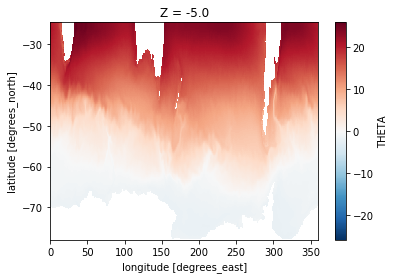

In [23]:
sst_mean.where(surface_mask).plot()

In [26]:
left_lon = 298
upper_lat = -65
right_lon = 360
lower_lat = -78

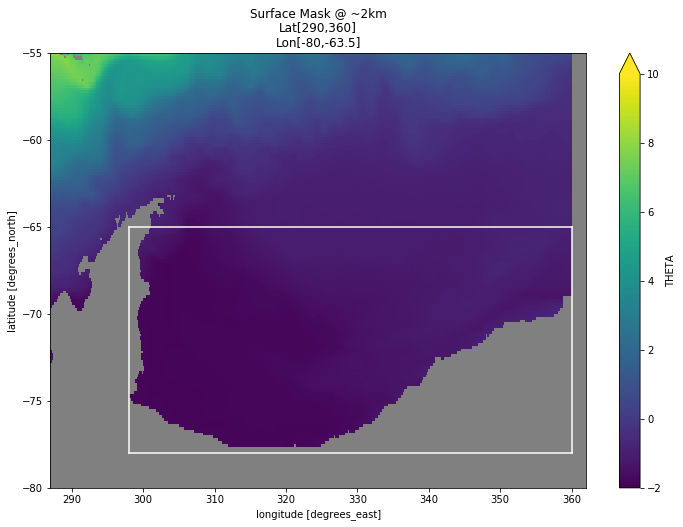

In [27]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ ~2km\nLat[290,360]\nLon[-80,-63.5]');

In [30]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [31]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [32]:
#advective flux
adv_flux_y = dsr.ADVy_TH.isel(**lon_range, YG=upper_lat).sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_TH.isel(**lat_range, XG=right_lon).sum(dim=['YC', 'Z']).load()

adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-13177336., -13868049., -15939710., ..., -13312121.,  -9721594.,
       -11875297.], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

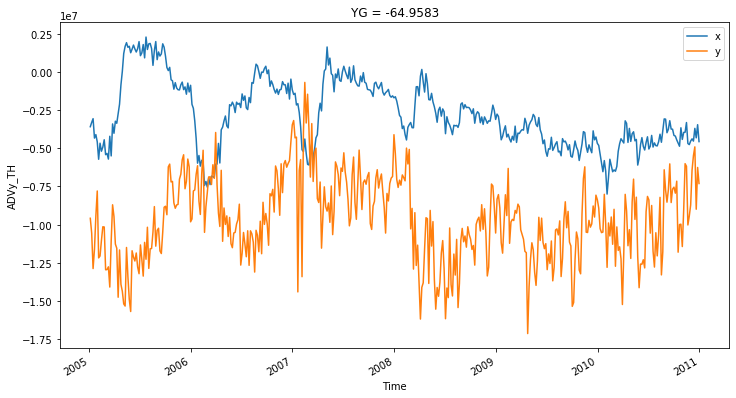

In [33]:
plt.figure(figsize=(12,6))

adv_flux_x.plot(label='x')
adv_flux_y.plot(label='y')
plt.legend()

In [34]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.isel(**lon_range, YG=upper_lat).sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_TH.isel(**lat_range, XG=right_lon).sum(dim=['YC', 'Z']).load()

diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ -7738.631 , -13908.878 ,  -6383.6543, ...,  37860.953 ,  43654.906 ,
        30965.42  ], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

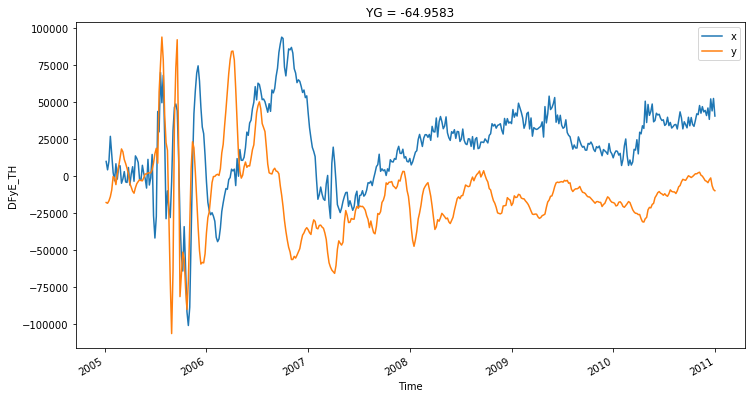

In [35]:
plt.figure(figsize=(12,6))
diff_flux_x.plot(label='x')
diff_flux_y.plot(label='y')
plt.legend()

In [36]:
#vertical flux
t_flux_z = (dsr.TFLUX.isel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([5.420727e+13, 6.273756e+13, 8.603774e+13, ..., 4.100215e+13,
       5.215819e+13, 8.668925e+13], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [40]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).isel(**lat_range, **lon_range).sum(dim=['XC', 'YC'])
#i noticed lin_fs_corr term didn't have `**lon_range` - should it not have?
#units: (˚C m^3)/s

In [38]:
surface_term.load()

In [41]:
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([-5951370.5 ,   511134.2 ,  -564776.1 , ...,  -875860.25,  -550849.06,
        -347501.28], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

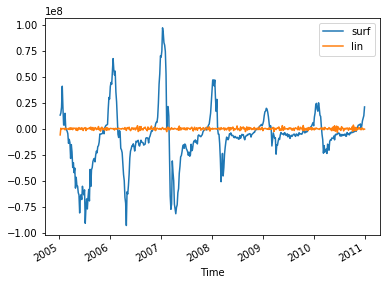

In [42]:
surface_term.plot(label='surf')
lin_fs_correction.plot(label='lin')
plt.legend()

In [43]:
tottend_weddell = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC).isel(
                                                   **lon_range, **lat_range).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([20346913.374815, 29569858.37037 , 36194607.407407, ..., 22317180.397037,
       21744615.727407, 32467708.586667])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

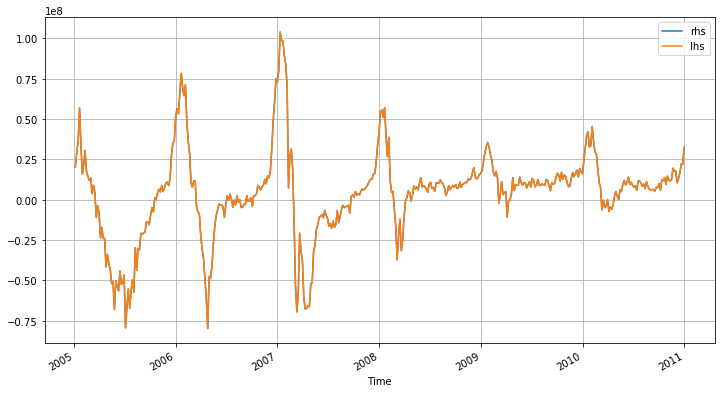

In [44]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend()
plt.grid();

In [49]:
adv_flux = - adv_flux
diff_flux = - diff_flux
adv_flux.load()
diff_flux.load()

<xarray.DataArray (time: 438)>
array([  7738.631 ,  13908.878 ,   6383.6543, ..., -37860.953 , -43654.906 ,
       -30965.42  ], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [50]:
all_terms = xr.merge([tottend_weddell.rename('tottend'),
                      adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG         float32 359.83334
    YG         float32 -64.9583
Data variables:
    tottend    (time) float64 2.035e+07 2.957e+07 ... 2.174e+07 3.247e+07
    adv_flux   (time) float32 13177336.0 13868049.0 ... 9721594.0 11875297.0
    diff_flux  (time) float32 7738.631 13908.878 ... -43654.906 -30965.42
    lin_fs     (time) float32 -5951370.5 511134.2 ... -550849.06 -347501.28
    surface    (time) float32 13113213.0 15176764.0 ... 12617523.0 20970888.0

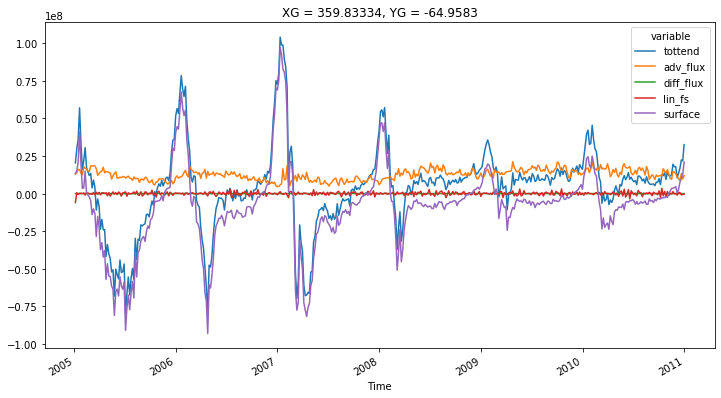

In [51]:
plt.figure(figsize=(12,6))
all_terms.to_array().plot.line(x='time')

In [52]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

,budget
variable,
tottend,4.242762e+06
adv_flux,1.248104e+07
diff_flux,-8.712521e+03
lin_fs,-1.829555e+04
surface,-8.211270e+06


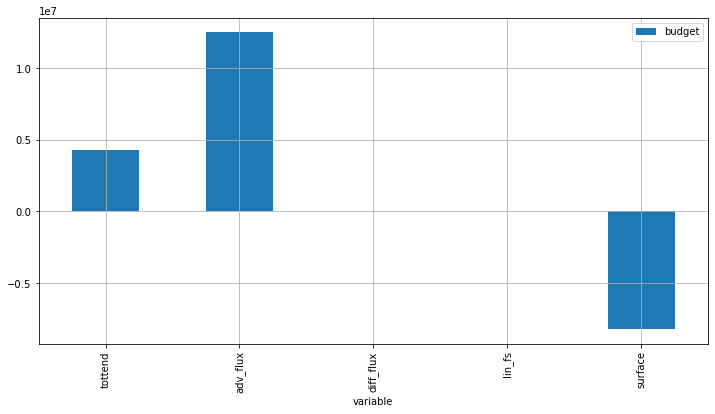

In [53]:
df.plot(figsize=(12,6), kind='bar')
plt.grid();

## Heat budget for Lower WG (-2,046m to bottom)

In [ ]:
dsr.Z[27]

In [5]:
sst_mean_lower = dsr.THETA.isel(Z=27).mean(dim='time').load()

In [6]:
surface_mask_lower = (coords.hFacC.isel(Z=17)>0).load()

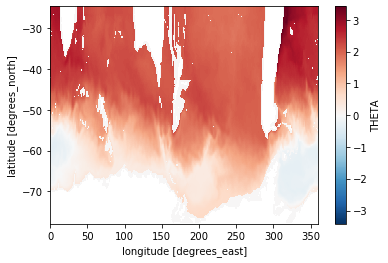

In [7]:
sst_mean_lower.where(surface_mask_lower).plot()

In [8]:
left_lon = 299
upper_lat = -66
right_lon = 360
lower_lat = -78

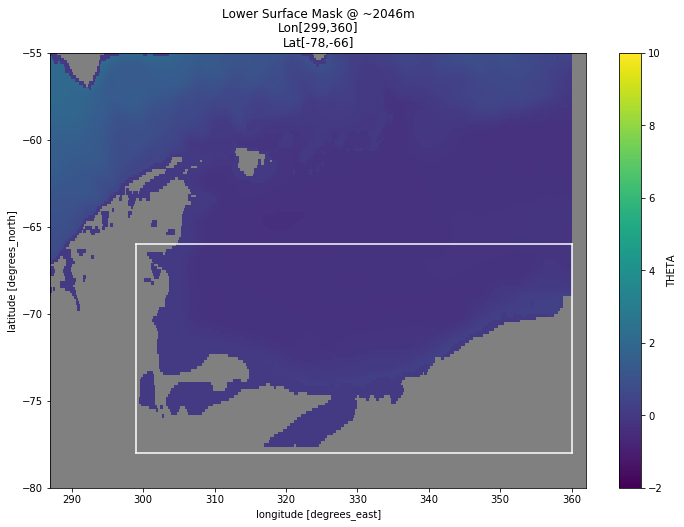

In [9]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean_lower.where(surface_mask_lower)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Lower Surface Mask @ ~2046m\nLon[299,360]\nLat[-78,-66]');

In [8]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 0
upper_lat_lower = 71
left_lon_lower = 1794
right_lon_lower = 2159

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [9]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))

In [10]:
#advective flux
adv_flux_y_lower = dsr.ADVy_TH.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['XC','Z']).load()
adv_flux_x_lower = dsr.ADVx_TH.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['YC','Z']).load()
adv_flux_z_lower = dsr.ADVr_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC']).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-2421230.5 ,  -529339.4 , -2847650.8 , ..., -1889367.1 ,  -214636.23,
       -2014028.  ], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -66.12497
    Zl       float32 -1904.0

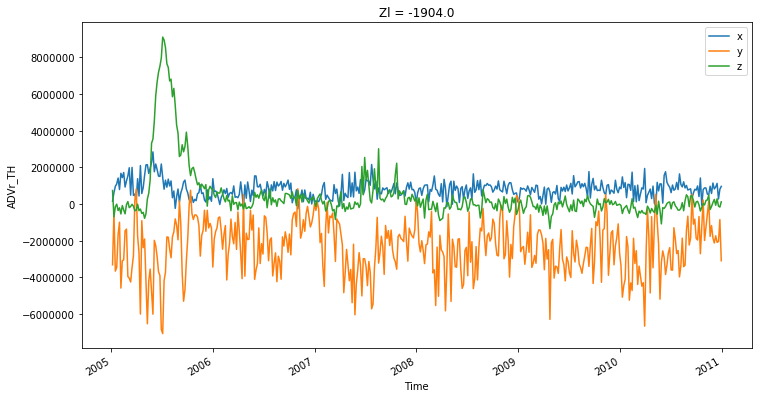

In [11]:
plt.figure(figsize=(12,6))
adv_flux_x_lower.plot(label='x')
adv_flux_y_lower.plot(label='y')
adv_flux_z_lower.plot(label='z')
plt.legend();

In [12]:
#diffusive flux
diff_flux_y_lower = dsr.DFyE_TH.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['XC','Z']).load()
diff_flux_x_lower = dsr.DFxE_TH.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['YC','Z']).load()
diff_flux_z_lower =  ((dsr.DFrE_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + dsr.DFrI_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + dsr.KPPg_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-2.093874e+07,  1.319831e+04,  1.194280e+04, ...,  7.516209e+03,
        1.212570e+04,  1.274360e+04], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -66.12497
    Zl       float32 -1904.0

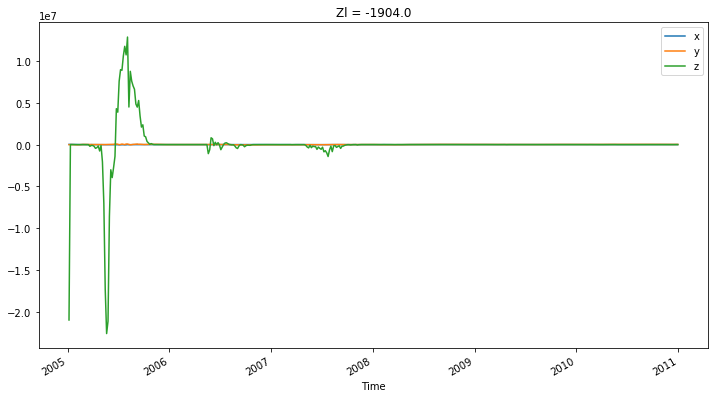

In [13]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='x')
diff_flux_y_lower.plot(label='y')
diff_flux_z_lower.plot(label='z')
plt.legend()

In [14]:
tottend_weddell_lower = ((dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                            dim=['XC', 'YC','Z']))/ (24*60*60)
tottend_weddell_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([23359968.900741,   516140.942222,  2835707.828148, ...,  1881851.06963 ,
         202510.672593,  2001284.551111])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

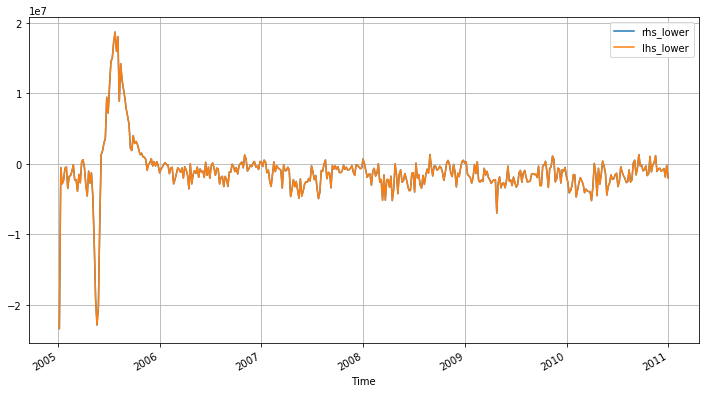

In [15]:
plt.figure(figsize=(12,6))
rhs_lower = adv_flux_lower + diff_flux_lower
lhs_lower = -tottend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();

In [16]:
all_terms_lower = xr.merge([adv_flux_lower.rename('adv_flux'), 
                            diff_flux_lower.rename('diff_flux'),
                            tottend_weddell_lower.rename('tottend')])
all_terms_lower

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
    XG         float32 359.83334
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG         float32 -66.12497
    Zl         float32 -1904.0
Data variables:
    adv_flux   (time) float32 -2421230.5 -529339.4 ... -214636.23 -2014028.0
    diff_flux  (time) float32 -20938738.0 13198.307 ... 12125.698 12743.604
    tottend    (time) float64 2.336e+07 5.161e+05 ... 2.025e+05 2.001e+06

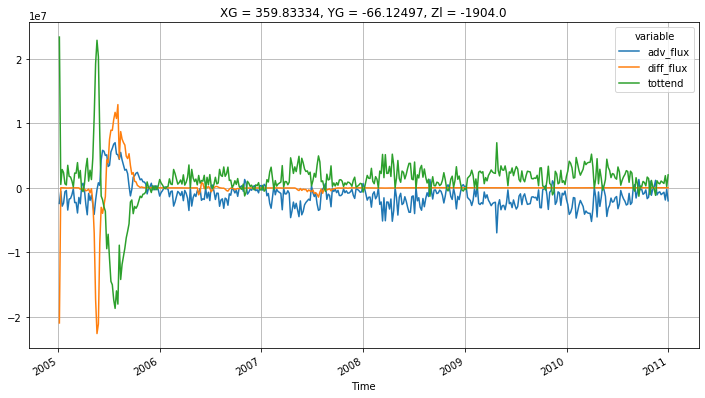

In [56]:
plt.figure(figsize=(12,6))
all_terms_lower.to_array().plot.line(x='time')
plt.grid();

In [17]:
df_lower = all_terms_lower.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df_lower

,budget
variable,
adv_flux,-1.098489e+06
diff_flux,2.233703e+04
tottend,1.076152e+06


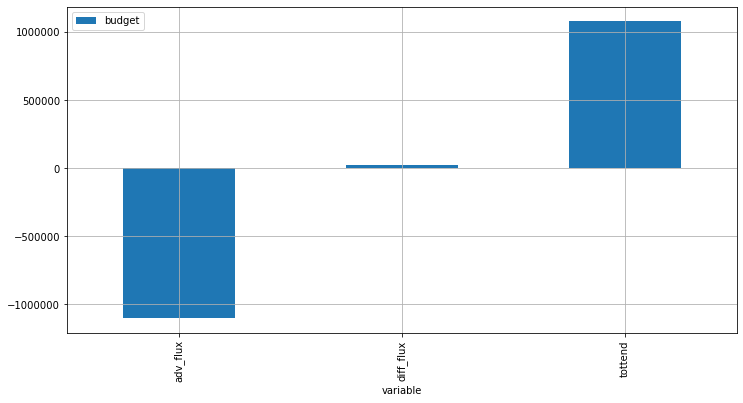

In [18]:
df_lower.plot(figsize=(12,6), kind='bar')
plt.grid()

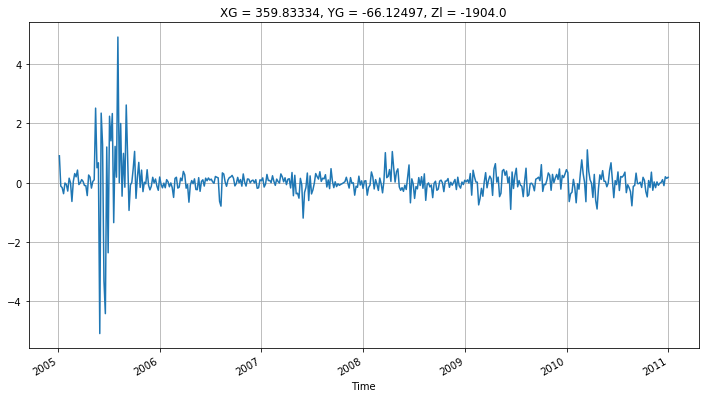

In [19]:
(rhs_lower - lhs_lower).plot(figsize=(12,6))
plt.grid();